In [1]:
import os
import sys
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import json
import numpy as np
import math
import seaborn as sns
# sns.set_theme()

from typing import Optional

from datetime import timedelta

from src.utils import (
    create_dataset, plot_spectrogram,
    RandomClip, extract_logmel
)
from src.datasets import VoxCelebDataModule
from src.models import SEBlock, SpeakerRecognitionModel, build_efficientnetv2
from torch import nn
from sklearn.decomposition import PCA

from src.losses import SubCenterAAMSoftmaxLoss
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [4]:
SAMPLE_WAV_SPEECH_PATH = "E:\Datasets\VoxCeleb1\\vox1_dev\id10001\\1zcIwhmdeo4\\00001.wav"
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [5]:
waveform, sample_rate

(tensor([[ 0.0703,  0.0703,  0.0916,  ..., -0.0863, -0.1171, -0.1537]]), 16000)

In [6]:
waveform.shape

torch.Size([1, 129921])

In [7]:
rc = RandomClip()

In [9]:
clipped = rc(waveform)
clipped.shape

torch.Size([1, 48000])

In [14]:
n_fft = 512
mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=400,
        hop_length=160,
        center=True,
        pad_mode="reflect",
        power=2.0, # energy instead of power
        norm="slaney",
        onesided=True,
        n_mels=80,
        mel_scale="htk",
    )

In [ ]:
cmn = T.SlidingWindowCmn(cmn_window=n_fft)
to_db = T.AmplitudeToDB(stype="amplitude")

In [15]:
logmel = mel_spectrogram(clipped)
logmel.shape

torch.Size([1, 80, 301])

In [16]:
logmel

tensor([[[7.8277e-02, 5.5358e-06, 1.5163e-04,  ..., 1.6768e-04,
          7.0155e-04, 1.2434e-02],
         [1.0813e-01, 1.3313e-03, 2.3459e-04,  ..., 1.4938e-04,
          1.4397e-03, 8.2372e-03],
         [1.6375e-01, 3.7800e-03, 3.8877e-04,  ..., 1.1664e-04,
          2.8075e-03, 5.6519e-04],
         ...,
         [1.6311e-04, 7.1723e-05, 2.0904e-04,  ..., 5.5493e-04,
          1.0544e-04, 1.9579e-04],
         [2.9733e-05, 7.2198e-05, 1.3902e-04,  ..., 4.5451e-05,
          5.7620e-05, 1.1855e-04],
         [2.4860e-05, 1.2920e-05, 3.6136e-05,  ..., 2.8188e-05,
          3.4338e-05, 7.0733e-06]]])

In [20]:
logmel = extract_logmel(clipped, sample_rate=16000, n_mels=80)
logmel.shape

torch.Size([1, 80, 301])

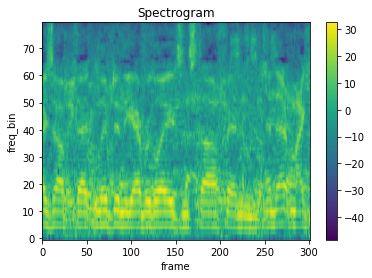

In [21]:
plot_spectrogram(logmel[0])

In [29]:
freq_masking = T.FrequencyMasking(freq_mask_param=10)
time_masking = T.TimeMasking(time_mask_param=5)

In [38]:
spec_logmel = time_masking(freq_masking(logmel))

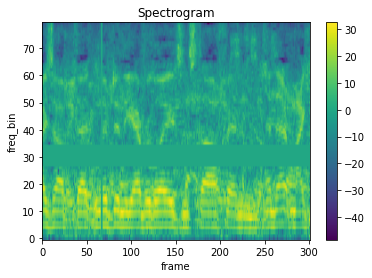

In [39]:
plot_spectrogram(time_masking(freq_masking(logmel))[0])

In [3]:
create_dataset(num_speakers=8, to_db_flag=False, cmn_flag=False)

train    757
test      51
val       43
Name: Set, dtype: int64
Num speakers: 8
Male ratio in dataset: 0.5515587529976019
Female ratio in dataset: 0.44844124700239807
Male sampled ratio: 0.5
Female sampled ratio: 0.5
Num sampled males: 4
Num sampled females: 4



In [ ]:
num_secs = 3
csv_base_path: str = "E:/Datasets/VoxCeleb1/subset/"
set_name: str = "train"
df = pd.read_csv(
            csv_base_path + f"subset_features_{num_secs}.csv"
        )

In [ ]:
df

In [ ]:
label_dict = pd.read_csv(
            csv_base_path + f"subset_labels_{num_secs}.csv"
        ).to_dict()["label"]

In [ ]:
label_dict

In [ ]:
melspecs = []
y = []
for idx, row in df.iterrows():
    melspec = torch.load(row["File"]).numpy()
    melspecs.append(
        melspec
    )
    y.append(
        label_dict[row["Speaker"]]
    )

In [ ]:
X = np.vstack(melspecs)
X.shape

In [ ]:
X = X.reshape(X.shape[0], 80*301)
X.shape

In [ ]:
y = np.vstack(y).squeeze(-1)
y.shape

In [ ]:
kmeans = KMeans(n_clusters=8)

In [ ]:
kmeans.fit(X)

In [ ]:
pca = PCA(2)

In [ ]:
Xpca = pca.fit_transform(X)

In [ ]:
u_y = np.unique(y)

In [ ]:
y

In [ ]:
Xpca[y == 0]

In [ ]:
for label in u_y:
    plt.scatter(
        Xpca[y == label, 0], 
        Xpca[y == label, 1], 
        label=label,
        alpha=0.7
    )
plt.legend()
plt.show()

In [ ]:
svc = SVC()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
svc.fit(X_train,y_train)

In [ ]:
pred = svc.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
mlp = MLPClassifier()

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
pred = mlp.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)